***AsthmaSCELNet: A Lightweight Supervised Contrastive Embedding Learning Framework For Asthma Classification Using Lung Sounds***
 *Submitted to: Interspeech, 2023, Dublin, Ireland \\
Coder: Arka Roy, PMRF, IIT Patna*

**Methodology of AsthmaSCELNet**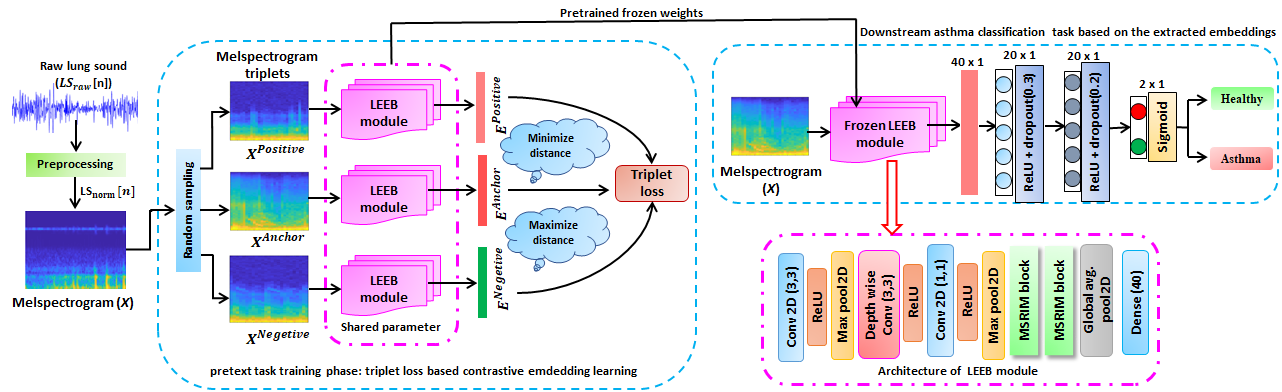

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install mat73
import mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keras==2.2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 312 kB 14.4 MB/s 
     |████████████████████████████████| 50 kB 9.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.2.4 which is incompatible.


In [ ]:
!pip install tensorflow==2.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.6 MB 5.5 kB/s 
     |████████████████████████████████| 5.8 MB 15.1 MB/s 
     |████████████████████████████████| 462 kB 98.2 MB/s 
     |████████████████████████████████| 1.4 MB 62.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully u

**Mount Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Load Signal Data**

In [ ]:
sig_dict=mat73.loadmat('/content/gdrive/MyDrive/ARKA/Asthma_classification/all_sigs.mat')
sig=sig_dict['all_sig'];
sig=sig.transpose()
sig.shape

(1362, 20000)

**Labels**

In [ ]:
labels=pd.read_excel('/content/gdrive/MyDrive/ARKA/Asthma_classification/labels.xlsx',header=None)
l=np.array(labels)
l_new=np.reshape(l,(l.shape[0],))

**Create Melspectrogram and Convert Them To 3channel RGB Image**

In [ ]:
import librosa
r=len(sig[:,1])
nfft=1024
win_length=1024
hop_length=410;sr=4000
audio_rgb_list=[]
d_shape=224

import cv2 as cvlib
for i in range (r):
  clip=sig[i,:]
  mel_spec=librosa.feature.melspectrogram( y=clip, sr=4000,n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann')
  log_spectrogram = librosa.amplitude_to_db(mel_spec)
  norm=(log_spectrogram-np.min(log_spectrogram))/(np.max(log_spectrogram)-np.min(log_spectrogram))
  img = norm
  img=cvlib.resize(img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
  cmap = plt.get_cmap('jet')
  rgba_img = cmap(img)
  rgb_img = np.delete(rgba_img, 3, 2)
  clip_rgb=np.flip(rgb_img, 0)
  audio_rgb_list.append(clip_rgb)

X=np.array(audio_rgb_list)
print('shape of one spectrogram dataset'+str(np.shape(audio_rgb_list)))

shape of one spectrogram dataset(1362, 224, 224, 3)


In [ ]:
'''#save to drive
import pickle
filename = '/content/gdrive/MyDrive/ARKA/Sound_Classification_Problem/melspectrograms_magma'
outfile = open(filename,'wb')
pickle.dump(X,outfile)
outfile.close()

In [ ]:
'''import pickle
filename='/content/gdrive/MyDrive/ARKA/Sound_Classification_Problem/melspectrograms_magma'
infile = open(filename,'rb')
X = pickle.load(infile)
infile.close()
print('shape of segmented audio : '+str(np.shape(X)))

**Splitting the entire dataset into 80-20 ratio**

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X and l_new are valid input arrays
X_train_1, X_test, Y_train_1, Y_test = train_test_split(X, l_new, test_size=0.1, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_1, Y_train_1, test_size=0.1, random_state=22)


NameError: ignored

**Generate Triplets and Create a Helper Function To Plot Them**

In [ ]:
import random
def plot_triplets(examples):
    plt.figure(figsize=(18, 3))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (224,224,3)))
        plt.xticks([])
        plt.yticks([])
        if i==0:
          plt.title('Anchor');
        elif i==1:
          plt.title('Positive')
        elif i==2:
          plt.title('Negetive')
    plt.show()

In [ ]:
def create_batch_train(batch_size):
    x_anchors_train = [];
    x_positives_train = [];
    x_negatives_train = [];

    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, X_train.shape[0] - 1)
        x_anchor = X_train[random_index]
        y = Y_train[random_index]

        indices_for_pos = np.squeeze(np.where(Y_train == y)); final_pos_idx=indices_for_pos[random.randint(0, len(indices_for_pos) - 1)];
        indices_for_neg = np.squeeze(np.where(Y_train != y)); final_neg_idx=indices_for_neg[random.randint(0, len(indices_for_neg) - 1)];

        x_positive = X_train[final_pos_idx];
        x_negative = X_train[final_neg_idx];

        x_anchors_train.append(x_anchor) ;
        x_positives_train.append(x_positive)
        x_negatives_train.append(x_negative)

    x_anchors_train=np.array(x_anchors_train)
    x_positives_train=np.array(x_positives_train)
    x_negatives_train=np.array(x_negatives_train)
    return [x_anchors_train, x_positives_train, x_negatives_train]

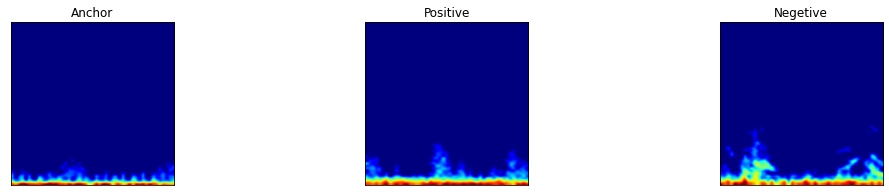

In [ ]:
examples = create_batch_train(1)
plot_triplets(examples)

**MSRIM Module for LEEB - Network inside Network (NiN structure)**
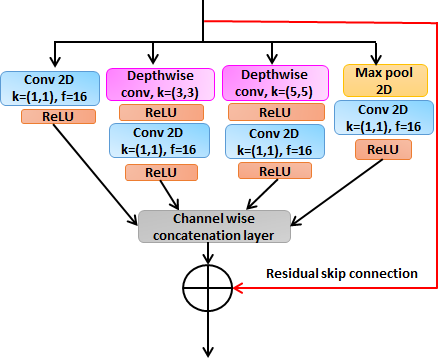

In [ ]:
import tensorflow
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers import Input, Lambda
from keras.regularizers import l2
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.layers.core import Lambda
import keras

In [ ]:
'''def abs_backend(inputs):
    return K.abs(inputs)

def expand_dim_backend(inputs):
    return K.expand_dims(K.expand_dims(inputs,1),1)

def sign_backend(inputs):
    return K.sign(inputs)

def pad_backend(inputs, in_channels, out_channels):
    pad_dim = (out_channels - in_channels)//2
    inputs = K.expand_dims(inputs,-1)
    inputs = K.spatial_3d_padding(inputs, ((0,0),(0,0),(pad_dim,pad_dim)), 'channels_last')
    return K.squeeze(inputs, -1)

# Residual Shrinakge Block
def residual_shrinkage_block(incoming, nb_blocks, out_channels, downsample=False,
                             downsample_strides=2):

    residual = incoming
    in_channels = incoming.get_shape().as_list()[-1]

    for i in range(nb_blocks):

        identity = residual

        if not downsample:
            downsample_strides = 1

        residual = BatchNormalization()(residual)
        residual = Activation('relu')(residual)
        residual = Conv2D(out_channels, 3, strides=(downsample_strides, downsample_strides),
                          padding='same', kernel_initializer='he_normal',
                          kernel_regularizer=l2(1e-4))(residual)

        residual = BatchNormalization()(residual)
        residual = Activation('relu')(residual)
        residual = Conv2D(out_channels, 3, padding='same', kernel_initializer='he_normal',
                          kernel_regularizer=l2(1e-4))(residual)

        # Calculate global means
        residual_abs = Lambda(abs_backend)(residual)
        abs_mean = GlobalAveragePooling2D()(residual_abs)

        # Calculate scaling coefficients
        scales = Dense(out_channels, activation=None, kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(abs_mean)
        scales = BatchNormalization()(scales)
        scales = Activation('relu')(scales)
        scales = Dense(out_channels, activation='sigmoid', kernel_regularizer=l2(1e-4))(scales)
        scales = Lambda(expand_dim_backend)(scales)

        # Calculate thresholds
        thres = keras.layers.multiply([abs_mean, scales])

        # Soft thresholding
        sub = keras.layers.subtract([residual_abs, thres])
        zeros = keras.layers.subtract([sub, sub])
        n_sub = keras.layers.maximum([sub, zeros])
        residual = keras.layers.multiply([Lambda(sign_backend)(residual), n_sub])

        # Downsampling using the pooL-size of (1, 1)
        if downsample_strides > 1:
            identity = AveragePooling2D(pool_size=(1,1), strides=(2,2))(identity)

        # Zero_padding to match channels
        if in_channels != out_channels:
            identity = Lambda(pad_backend, arguments={'in_channels':in_channels,'out_channels':out_channels})(identity)

        residual = keras.layers.add([residual, identity])

    return residual '''

In [ ]:
def mobile_inception(dim):
    print("\nTRAINING ON mobile_inception MODEL:-")


    def block(x, filters, reps):
        for _ in range(reps):
            # for low-level features
            t1 = Conv2D(filters[0], kernel_size = (1,1))(x)
            t1 = LeakyReLU()(t1)

            # for mid-level features
            t2 = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
            t2 = LeakyReLU()(t2)
            t2 = Conv2D(filters[1], kernel_size = (1,1))(t2)
            t2 = LeakyReLU()(t2)

            # for high-level features
            t3 = DepthwiseConv2D(kernel_size = (5,5), strides = 1, padding = 'same')(x)
            t3 = LeakyReLU()(t3)
            t3 = Conv2D(filters[2], kernel_size = (1,1))(t3)
            t3 = LeakyReLU()(t3)

            # for most-significant features
            t4 = MaxPool2D(pool_size = (3,3), strides = 1, padding = 'same')(x)
            t4 = Conv2D(filters[3], kernel_size = (1,1))(t4)
            t4 = LeakyReLU()(t4)

            x = Concatenate()([t1, t2, t3, t4])

        return x


    input = Input(shape = dim)

    k = 16

    x = Conv2D(filters = k, kernel_size = (3,3), strides = 2, padding = 'same')(input)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same')(x)

    x = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters = 2*k, kernel_size = (1,1))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)

    x = block(x, [k, k, k, k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)

    x = GlobalAveragePooling2D()(x)
    output=  Dense(40, 'relu')(x)

    model = Model(inputs = input, outputs = output)

    return model

In [ ]:
'''def embedding_model():
  inputs = Input(shape=(64,64,3))
  net = Conv2D(32, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
  net = residual_shrinkage_block(net, 1, 64, downsample=True)
  net = BatchNormalization()(net)
  net = Activation('relu')(net)
  output = GlobalAveragePooling2D()(net)
  model = Model(inputs=inputs, outputs=output)
  return model '''

In [ ]:
def embedding_model():
    dim = (224,224,3)
    model = mobile_inception(dim)
    return model


In [ ]:
base_model = embedding_model()
base_model.summary()


TRAINING ON mobile_inception MODEL:-
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 112, 112, 16  0           ['conv2d[0][0]']                 
                                )                       

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [ ]:
dim=(224,224,3)
input_anchor = Input(shape=(dim))
input_positive = tf.keras.layers.Input(shape=(dim))
input_negative = tf.keras.layers.Input(shape=(dim))

embedding_anchor = base_model(input_anchor)
embedding_positive = base_model(input_positive)
embedding_negative = base_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = Model([input_anchor, input_positive, input_negative], output)
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                          

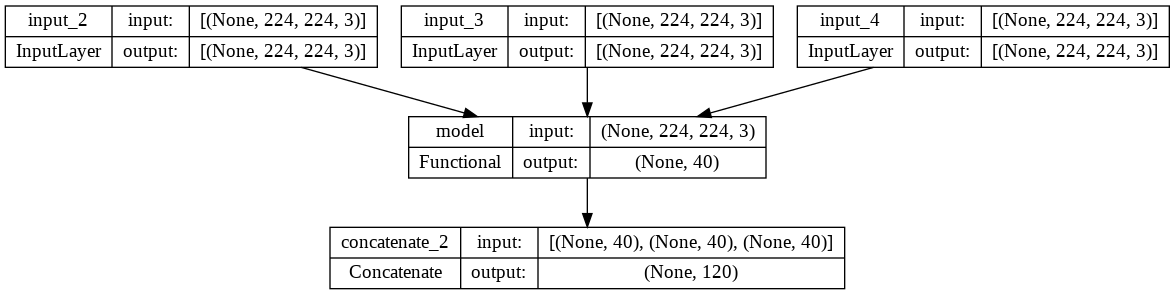

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
emb_size=40
def train_data_generator(batch_size=256):
    while True:
        x_t = create_batch_train(batch_size)
        y_t = np.zeros((batch_size, 3*emb_size))
        yield x_t, y_t


In [ ]:
steps_per_epoch = int(X_train.shape[0]/batch_size)
opt =tf.keras.optimizers.Adam(learning_rate=0.008)
net.compile(loss=triplet_loss, optimizer=opt)

In [ ]:
batch_size = 64
epochs = 400
history =net.fit(train_data_generator(batch_size),steps_per_epoch=steps_per_epoch,epochs=epochs, verbose=1)#validation_data=test_generator,

Epoch 1/400
8/8 [==============================] - 3s 294ms/step - loss: 0.0832
Epoch 2/400
8/8 [==============================] - 4s 491ms/step - loss: 0.0759
Epoch 3/400
8/8 [==============================] - 2s 299ms/step - loss: 0.0662
Epoch 4/400
8/8 [==============================] - 2s 298ms/step - loss: 0.0576
Epoch 5/400
8/8 [==============================] - 2s 202ms/step - loss: 0.0494
Epoch 6/400
8/8 [==============================] - 2s 228ms/step - loss: 0.0612
Epoch 7/400
8/8 [==============================] - 2s 276ms/step - loss: 0.0603
Epoch 8/400
8/8 [==============================] - 2s 273ms/step - loss: 0.0699
Epoch 9/400
8/8 [==============================] - 3s 367ms/step - loss: 0.0458
Epoch 10/400
8/8 [==============================] - 1s 144ms/step - loss: 0.0549
Epoch 11/400
8/8 [==============================] - 2s 281ms/step - loss: 0.0634
Epoch 12/400
8/8 [==============================] - 2s 214ms/step - loss: 0.0633
Epoch 13/400
8/8 [===================

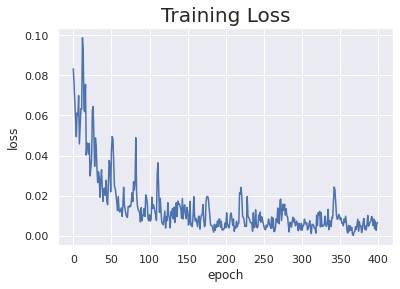

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Training Loss',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels):
    # Create a scatter plot of all the
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels)

In [ ]:
# Using the newly trained model compute the embeddings
# for a number images
from sklearn.manifold import TSNE
X_train_trm = net.layers[3].predict(X_train)

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training instances embedding')

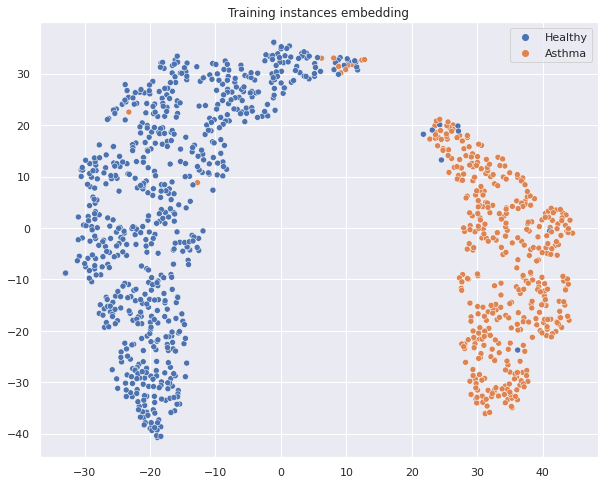

In [ ]:
scatter(train_tsne_embeds, Y_train)
plt.title('Training instances embedding')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation instances embedding')

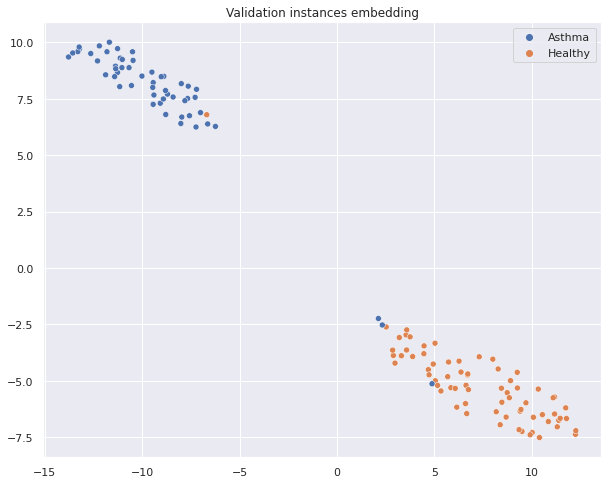

In [ ]:
X_val_trm = net.layers[3].predict(X_val)

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
val_tsne_embeds = tsne.fit_transform(X_val_trm)
scatter(val_tsne_embeds, Y_val)
plt.title('Validation instances embedding')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Testing instances embedding')

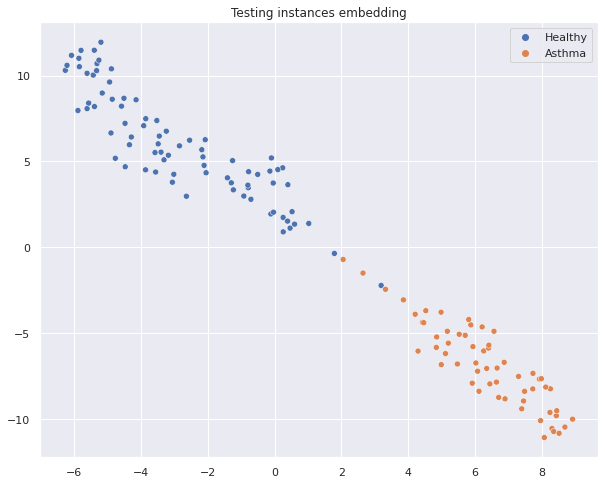

In [ ]:
X_test_trm = net.layers[3].predict(X_test)

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
test_tsne_embeds = tsne.fit_transform(X_test_trm)
scatter(test_tsne_embeds, Y_test)
plt.title('Testing instances embedding')

In [ ]:
import os
from datetime import date
today = date.today()
f_date=today.strftime("%d_%m_%y")
os.mkdir("/content/gdrive/My Drive/ARKA/Asthma_classification/train_on_"+(f_date))
new_loc="/content/gdrive/My Drive/ARKA/Asthma_classification/train_on_"+(f_date)

In [ ]:
from keras.models import model_from_json
model_json = net.to_json()
with open(new_loc+"/triplet_mobile_inception.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
    from pytz import timezone
    from datetime import datetime
    ind_time = datetime.now(timezone("Asia/Kolkata")).strftime('%Y_%m_%d_%H_%M_%S')
    # save model
    net.save_weights(new_loc+'/triplet'+'_'+str(ind_time)+'.h5')
    print("===================================done=============================================================")

===================================done=============================================================


**Design Classifier With GLU Layer**

In [ ]:

output_neurons=2
output_activation='sigmoid'

ips = Input(shape=(40,))
#x = net.layers[3] (ips)
t1= Dense(20, 'relu')(ips)
t1=Dropout(0.2)(t1)
t1= Dense(20, 'relu')(t1)
t1=Dropout(0.2)(t1)
output = Dense(output_neurons, output_activation)(t1)

classifier_model = Model(inputs=ips, outputs=output)
classifier_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_4 (Dense)             (None, 20)                820       
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 42        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable p

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(classifier_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_train_trm = net.layers[3].predict(X_train)
Y_train_df=pd.DataFrame(Y_train,columns = ['Lung_Sound'])
class_label_onehot_ytr=pd.get_dummies(Y_train_df)
Y_train_l=np.array(class_label_onehot_ytr);

print(Y_train_l.shape)

(1102, 2)


In [ ]:
X_val_trm = net.layers[3].predict(X_val)
Y_val_df=pd.DataFrame(Y_val,columns = ['Lung_Sound'])
class_label_onehot_yvl=pd.get_dummies(Y_val_df)
Y_val_l=np.array(class_label_onehot_yvl);

print(Y_val_l.shape)

(123, 2)


In [ ]:
X_test_trm = net.layers[3].predict(X_test)
Y_test_df=pd.DataFrame(Y_test,columns = ['Lung_Sound'])
class_label_onehot_ytst=pd.get_dummies(Y_test_df)
Y_tst_l=np.array(class_label_onehot_ytst);

print(Y_tst_l.shape)

(137, 2)


In [ ]:
opt =tf.keras.optimizers.Adam(learning_rate=0.008)
classifier_model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
history = classifier_model.fit(X_train_trm, Y_train_l, batch_size=128, epochs=400, verbose=1,validation_data=(X_val_trm, Y_val_l))

Epoch 1/400
9/9 [==============================] - 1s 8ms/step - loss: 0.1676 - accuracy: 0.9601 - val_loss: 0.1374 - val_accuracy: 0.9593
Epoch 2/400
9/9 [==============================] - 0s 4ms/step - loss: 0.1771 - accuracy: 0.9619 - val_loss: 0.1203 - val_accuracy: 0.9593
Epoch 3/400
9/9 [==============================] - 0s 4ms/step - loss: 0.1550 - accuracy: 0.9601 - val_loss: 0.0873 - val_accuracy: 0.9756
Epoch 4/400
9/9 [==============================] - 0s 4ms/step - loss: 0.1561 - accuracy: 0.9646 - val_loss: 0.0910 - val_accuracy: 0.9675
Epoch 5/400
9/9 [==============================] - 0s 4ms/step - loss: 0.1703 - accuracy: 0.9583 - val_loss: 0.1132 - val_accuracy: 0.9593
Epoch 6/400
9/9 [==============================] - 0s 4ms/step - loss: 0.1315 - accuracy: 0.9691 - val_loss: 0.0841 - val_accuracy: 0.9837
Epoch 7/400
9/9 [==============================] - 0s 4ms/step - loss: 0.1561 - accuracy: 0.9574 - val_loss: 0.0869 - val_accuracy: 0.9837
Epoch 8/400
9/9 [==========

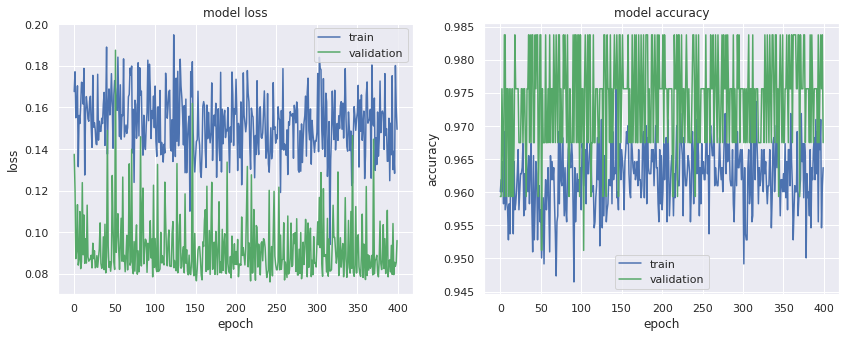

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'g-')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')

plt.subplot(122)
plt.plot(history.history['accuracy'],'b-')
plt.plot(history.history['val_accuracy'],'g-')
plt.title('model accuracy')
#plt.ylim(0,1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
from keras.models import model_from_json
model_json_classifier = classifier_model.to_json()
with open(new_loc+"/classifier.json", "w") as json_file:
    json_file.write(model_json_classifier)

In [ ]:
    from pytz import timezone
    from datetime import datetime
    ind_time = datetime.now(timezone("Asia/Kolkata")).strftime('%Y_%m_%d_%H_%M_%S')
    # save model
    classifier_model.save_weights(new_loc+'/classifiermodel_'+str(1)+'_'+str(ind_time)+'.h5')
    print("===================================done=============================================================")

===================================done=============================================================


In [ ]:
results=classifier_model.evaluate(X_test_trm,Y_tst_l,batch_size=32,verbose=1)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

5/5 [==============================] - 0s 2ms/step - loss: 0.0584 - accuracy: 0.9854
Test loss: 0.0584060363471508
Test accuracy: 0.985401451587677


In [ ]:
    from tqdm import tqdm
    # prediction using CNN
    predicted=classifier_model.predict(X_test_trm,batch_size=32,verbose=0)
    Y_pred=predicted.argmax(axis=-1)
    Y_predicted=pd.DataFrame(Y_tst_l,columns=['Asthma','Healthy'])
    Y_ori=[];Asthma_t=0;Normal_t=0;
    for index,row in tqdm(Y_predicted.iterrows()):
        if row['Asthma']==1:
          Asthma_t=Asthma_t+1
          Y_ori.append(0)
        elif row['Healthy']==1:
          Normal_t=Normal_t+1
          Y_ori.append(1)

    from sklearn.metrics import confusion_matrix
    import sklearn
    cm=confusion_matrix(Y_ori,Y_pred)
    print('Confusion Matrix');
    print(cm)
    precision = sklearn.metrics.precision_score(Y_ori,Y_pred)
    print('precision==   '+str(precision))
    accuracy=np.diag(cm).sum()/cm.sum().sum()
    print('Accuracy==    '+str(accuracy))
    recall = sklearn.metrics.recall_score(Y_ori,Y_pred)
    print('Recall==      '+str(recall))
    F1 = sklearn.metrics.f1_score(Y_ori,Y_pred)
    print('F1-Score==    '+str(F1))
    K_cappa = sklearn.metrics.cohen_kappa_score(Y_ori,Y_pred)
    print('Kcappa==      '+str(K_cappa))

137it [00:00, 21038.32it/s]

Confusion Matrix
[[57  1]
 [ 1 78]]
precision==   0.9873417721518988
Accuracy==    0.9854014598540146
Recall==      0.9873417721518988
F1-Score==    0.9873417721518988
Kcappa==      0.9701003928415539


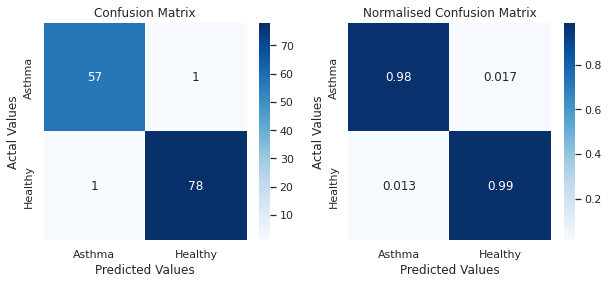

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_ori,Y_pred)
cm_norm=confusion_matrix(Y_ori,Y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



**Testing after revoking from drive**

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/triplet_mobile_inception.json', 'r')
triplet_model_json = json_file.read()
json_file.close()
triplet_model = model_from_json(triplet_model_json)
# load weights into new model
triplet_model.load_weights("/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/triplet_2022_08_18_19_34_55.h5")

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/classifier.json', 'r')
classifier_model_json = json_file.read()
json_file.close()
classifier_model = model_from_json(classifier_model_json)
# load weights into new model
classifier_model.load_weights("/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/classifiermodel_1_2022_08_18_19_34_20.h5")

In [ ]:
from sklearn.model_selection import train_test_split
X_train_1,X_test,Y_train_1,Y_test=train_test_split(X,l_new,test_size=0.1,random_state=10)
X_train,X_val,Y_train,Y_val=train_test_split(X_train_1,Y_train_1,test_size=0.1,random_state=10)

In [ ]:
embedding_out = triplet_model.layers[3].predict(X_test)

In [ ]:
    Y_test_df=pd.DataFrame(Y_test,columns = ['Lung_Sound'])
    class_label_onehot_ytst=pd.get_dummies(Y_test_df)
    Y_tst_l=np.array(class_label_onehot_ytst);
    from tqdm import tqdm
    # prediction using CNN
    predicted=classifier_model.predict(embedding_out)
    Y_pred=predicted.argmax(axis=-1)
    Y_predicted=pd.DataFrame(Y_tst_l,columns=['Asthma','Healthy'])
    Y_ori=[];Asthma_t=0;Normal_t=0;
    for index,row in tqdm(Y_predicted.iterrows()):
        if row['Asthma']==1:
          Asthma_t=Asthma_t+1
          Y_ori.append(0)
        elif row['Healthy']==1:
          Normal_t=Normal_t+1
          Y_ori.append(1)

    from sklearn.metrics import confusion_matrix
    import sklearn
    cm=confusion_matrix(Y_ori,Y_pred)
    print('Confusion Matrix');
    print(cm)
    precision = sklearn.metrics.precision_score(Y_ori,Y_pred)
    print('precision==   '+str(precision))
    accuracy=np.diag(cm).sum()/cm.sum().sum()
    print('Accuracy==    '+str(accuracy))
    recall = sklearn.metrics.recall_score(Y_ori,Y_pred)
    print('Recall==      '+str(recall))
    F1 = sklearn.metrics.f1_score(Y_ori,Y_pred)
    print('F1-Score==    '+str(F1))
    K_cappa = sklearn.metrics.cohen_kappa_score(Y_ori,Y_pred)
    print('Kcappa==      '+str(K_cappa))

137it [00:00, 13727.83it/s]

Confusion Matrix
[[57  1]
 [ 1 78]]
precision==   0.9873417721518988
Accuracy==    0.9854014598540146
Recall==      0.9873417721518988
F1-Score==    0.9873417721518988
Kcappa==      0.9701003928415539


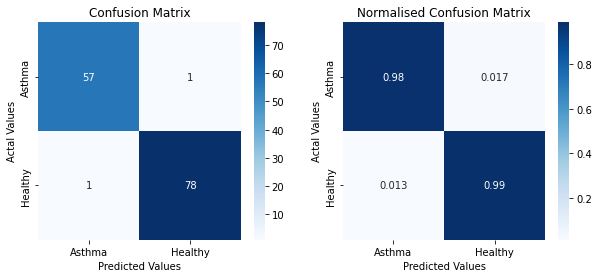

In [ ]:
import seaborn as sns;
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_ori,Y_pred)
cm_norm=confusion_matrix(Y_ori,Y_pred,normalize='true')
cm_df = pd.DataFrame(cm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])
plt.figure(figsize=(10,4))
plt.subplot(121)
sns.heatmap(cm_df,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

cm_df_norm = pd.DataFrame(cm_norm,
                     index = ['Asthma','Healthy'],
                     columns = ['Asthma','Healthy'])

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.title('Normalised Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



In [ ]:
np.shape(Y_ori)

(137,)

In [ ]:
np.shape(predicted)

(137, 2)

In [ ]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
Y_ori=np.array(Y_ori)
n_classes = 2 # number of class
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_ori, predicted[:,i],pos_label=i )
    roc_auc[i] = auc(fpr[i], tpr[i])
p=[]
for i in range (2):
  p.append(roc_auc[i])
p=np.array(p)
p_rounded=np.round(p,decimals=3)


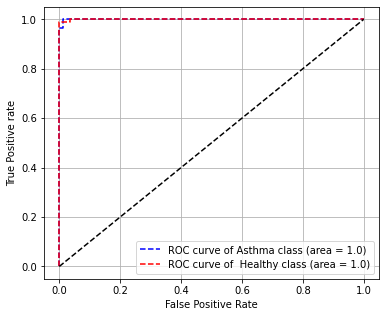

In [ ]:
# Plot the ROC chart
plt.figure(figsize=(6,5))
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='ROC curve of Asthma class (area = '+str(p_rounded[0])+')')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='ROC curve of  Healthy class (area = '+str(p_rounded[1])+')')
plt.plot([0, 1], [0, 1], 'k--');plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()

(0.5, 1.04)

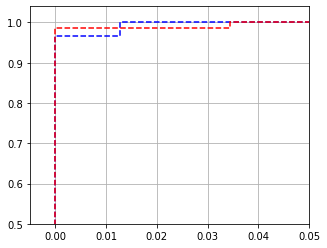

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red')

plt.xlim([-0.005,0.05]); plt.grid()
plt.ylim([0.5,1.04])

In [ ]:
fpr_asthma=fpr[0]
fpr_healthy=fpr[1]
np.savetxt('Asthma_roc_fpr.txt',fpr_asthma)
np.savetxt('healthy_roc_fpr.txt',fpr_healthy)

In [ ]:
tpr_asthma=tpr[0]
tpr_healthy=tpr[1]
np.savetxt('Asthma_roc_tpr.txt',tpr_asthma)
np.savetxt('healthy_roc_tpr.txt',tpr_healthy)

In [ ]:

np.savetxt('Y_ori.txt',Y_ori)
np.savetxt('Y_pred.txt',Y_pred)

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels):
    # We create a scatter plot.
    plt.figure(figsize=(10,8))
    sns.scatterplot(x[:,0], x[:,1], hue=labels)

In [ ]:
# Using the newly trained model compute the embeddings
# for a number images
from sklearn.manifold import TSNE
X_train_trm = triplet_model.layers[3].predict(X_train)

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training instances embedding')

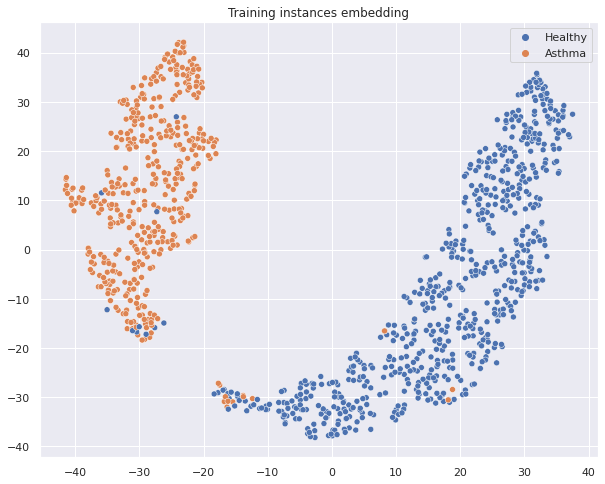

In [ ]:
scatter(train_tsne_embeds, Y_train)
plt.title('Training instances embedding')

In [ ]:
np.savetxt('tsne.txt',train_tsne_embeds)
np.savetxt('tsne_labels.txt',Y_train,'%s')

In [ ]:
from sklearn.model_selection import train_test_split
X_train_1,X_test,Y_train_1,Y_test=train_test_split(sig,l_new,test_size=0.1,random_state=10)
X_train,X_val,Y_train,Y_val=train_test_split(X_train_1,Y_train_1,test_size=0.1,random_state=10)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Raw Training instances embedding')

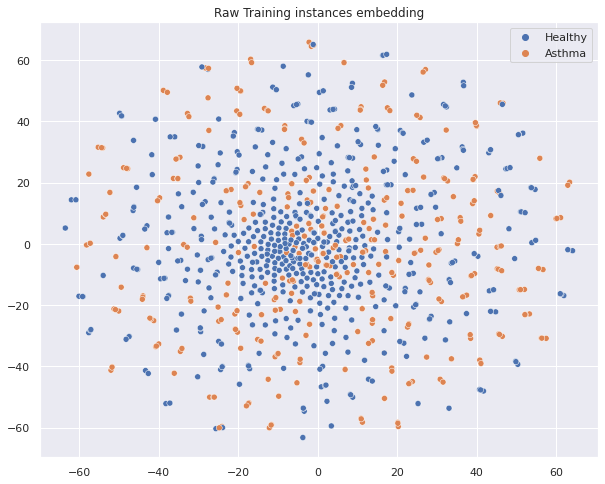

In [ ]:
train_tsne_embeds = tsne.fit_transform(X_train,'exact')
scatter(train_tsne_embeds, Y_train)
plt.title('Raw Training instances embedding')

In [ ]:
np.savetxt('raw_tsne.txt',train_tsne_embeds)

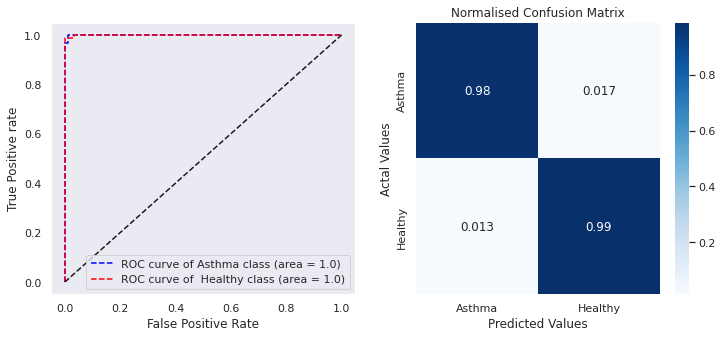

In [ ]:
# Plot the ROC chart
plt.figure(figsize=(12,5));plt.subplot(121)
plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='ROC curve of Asthma class (area = '+str(p_rounded[0])+')')
plt.plot(fpr[1], tpr[1], linestyle='--',color='red', label='ROC curve of  Healthy class (area = '+str(p_rounded[1])+')')
plt.plot([0, 1], [0, 1], 'k--');plt.grid()
plt.xlabel('False Positive Rate',)
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.subplot(122)
sns.heatmap(cm_df_norm,annot=True,cmap="Blues")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()


**REAL TIME TEST CODE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import scipy
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cvlib
from tensorflow.keras.models import Sequential, model_from_json
from scipy import signal
[sr,s]=read("healthy.wav");
fixed_win = 20000;
sliding_win =10000;
windowed_sig=[]

size_of_ip = np.size(s);
c = 0; j = 0;
while (1) :
  New = s[c:c+fixed_win]
  windowed_sig.append(New)
  c = c+sliding_win
  j = j+1
  if(c+fixed_win > size_of_ip):
      break
snippets=np.array(windowed_sig)
final_snip=[]
for i in range (len(snippets[:,1])):
  filt_snip=snippets[i,:];
  snip_norm=filt_snip/np.max(np.abs(filt_snip));
  final_snip.append(snip_norm)
final_snip=np.array(final_snip)

r=len(final_snip[:,1])
nfft=1024
win_length=1024
hop_length=410;sr=4000
audio_rgb_list=[]
audio2d_list=[]
d_shape=224


for i in range (r):
  clip=final_snip[i,:]
  t,f,log_spectrogram = signal.spectrogram(clip, fs=4000, window='hann',nperseg=1024,noverlap=410,nfft=1024)
  log_spectrogram=20*(np.abs(log_spectrogram))
  norm=(log_spectrogram-np.min(log_spectrogram))/(np.max(log_spectrogram)-np.min(log_spectrogram))
  img = norm
  img=cvlib.resize(img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
  cmap = plt.get_cmap('hsv')
  rgba_img = cmap(img)
  rgb_img = np.delete(rgba_img, 3, 2)
  clip_rgb=np.flip(rgb_img, 0)
  audio_rgb_list.append(clip_rgb)

print('shape of one spectrogram dataset'+str(np.shape(audio_rgb_list)))

json_file = open('/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/triplet_mobile_inception.json', 'r')
triplet_model_json = json_file.read()
json_file.close()
triplet_model = model_from_json(triplet_model_json)
# load weights into new model
triplet_model.load_weights("/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/triplet_2022_08_18_19_34_55.h5")


json_file = open('/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/classifier.json', 'r')
classifier_model_json = json_file.read()
json_file.close()
classifier_model = model_from_json(classifier_model_json)
# load weights into new model
classifier_model.load_weights("/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/classifiermodel_1_2022_08_18_19_34_20.h5")

X_test= np.array(audio_rgb_list)
embedding_out = triplet_model.layers[3].predict(X_test)
predicted=classifier_model.predict(embedding_out)
Y_pred=predicted.argmax(axis=-1)

for i in range (len(Y_pred)):
  frame_class_idx=Y_pred[i];
  if frame_class_idx==0:
    print('Frame_'+str(i)+': is predicted as: Asthma')
  else:
    print('Frame_'+str(i)+': is predicted as: Healthy')

shape of one spectrogram dataset(3, 224, 224, 3)
1/1 [==============================] - 0s 87ms/step
Frame_0: is predicted as: Asthma
Frame_1: is predicted as: Asthma
Frame_2: is predicted as: Asthma


In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cvlib
from tensorflow.keras.models import Sequential, model_from_json


[s,sr]=librosa.load("healthy.wav",res_type='kaiser_fast',sr=4000);
fixed_win = 20000;
sliding_win =10000;
windowed_sig=[]

size_of_ip = np.size(s);
c = 0; j = 0;
while (1) :
  New = s[c:c+fixed_win]
  windowed_sig.append(New)
  c = c+sliding_win
  j = j+1
  if(c+fixed_win > size_of_ip):
      break
snippets=np.array(windowed_sig)

final_snip=[]
for i in range (len(snippets[:,1])):
  filt_snip=snippets[i,:];
  snip_norm=filt_snip/np.max(np.abs(filt_snip));
  final_snip.append(snip_norm)
final_snip=np.array(final_snip)

r=len(final_snip[:,1])
nfft=1024
win_length=1024
hop_length=410;sr=4000
audio_rgb_list=[]
audio2d_list=[]
d_shape=224


for i in range (r):
  clip=final_snip[i,:]
  mel_spec=librosa.feature.melspectrogram( y=clip, sr=4000,n_mels=64, n_fft=1024, hop_length=410, win_length=1024, window='hann')
  log_spectrogram=librosa.amplitude_to_db(mel_spec)
  norm=(log_spectrogram-np.min(log_spectrogram))/(np.max(log_spectrogram)-np.min(log_spectrogram))
  img = norm
  img=cvlib.resize(img, dsize=(d_shape,d_shape), interpolation=cvlib.INTER_CUBIC)
  cmap = plt.get_cmap('jet')
  rgba_img = cmap(img)
  rgb_img = np.delete(rgba_img, 3, 2)
  clip_rgb=np.flip(rgb_img, 0)
  audio_rgb_list.append(clip_rgb)

print('shape of one spectrogram dataset'+str(np.shape(audio_rgb_list)))


json_file = open('/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/triplet_mobile_inception.json', 'r')
triplet_model_json = json_file.read()
json_file.close()
triplet_model = model_from_json(triplet_model_json)
# load weights into new model
triplet_model.load_weights("/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/triplet_2022_08_18_19_34_55.h5")


json_file = open('/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/classifier.json', 'r')
classifier_model_json = json_file.read()
json_file.close()
classifier_model = model_from_json(classifier_model_json)
# load weights into new model
classifier_model.load_weights("/content/gdrive/MyDrive/ARKA/Asthma_classification/train_on_18_08_22/classifiermodel_1_2022_08_18_19_34_20.h5")

X_test= np.array(audio_rgb_list)
embedding_out = triplet_model.layers[3].predict(X_test)
predicted=classifier_model.predict(embedding_out)
Y_pred=predicted.argmax(axis=-1)

for i in range (len(Y_pred)):
  frame_class_idx=Y_pred[i];
  if frame_class_idx==0:
    print('Frame_'+str(i)+': is predicted as: Asthma')
  else:
    print('Frame_'+str(i)+': is predicted as: Healthy')

shape of one spectrogram dataset(3, 224, 224, 3)
1/1 [==============================] - 0s 50ms/step
Frame_0: is predicted as: Healthy
Frame_1: is predicted as: Healthy
Frame_2: is predicted as: Healthy
